# Probabilistic programming from scratch

1. A/B testing with ABC
2. Functional Python and online learning
3. Improving performance and the German Tank Problem

Inspirations:

 - [Statistics for Hackers, Jake VanderPlas](https://www.youtube.com/watch?v=Iq9DzN6mvYA)
 - [Loop like a Native, Ned Batchelder](https://nedbatchelder.com/text/iter.html)
 - [Stupid itertools tricks for data science, Joel Grus](https://github.com/joelgrus/stupid-itertools-tricks-pydata)
 - [Data Science from Scratch, Joel Grus](https://github.com/joelgrus/data-science-from-scratch)
 - [Orioles](https://www.safaribooksonline.com/oriole/getting-started-with-deep-learning-using-keras-and-python)

## 1. A/B testing with ABC
 
Real world observational data is imperfect or incomplete. The process of learning from it, while quantifying uncertainty, is known as inference.

### A/B testing

Let's consider a concrete problem: an A/B test. Our goal is to determine if layout A is better than layout B. Better is defined in terms of "conversion": the fraction of visitors registered or signed up. Say 4% of visitors shown layout A convert, and 5% of layout B. Clearly layout B is better, right? Well, what if it was actually a short A/B test:

In [1]:
na = 100
obsa = 4
nb = 40
obsb = 2

Are you still sure B is better? And what if it's going to cost you $1m to change the layout of your website. Do you still feel sure? 

What we'd really like is to be able to quantify how confident we are.

This is the algorithm we're going to use to do that.

 - generate a trial value for the conversion fraction
 - simulate data assuming the trial value
 - if the simulation looks like the real data, keep the trial value, otherwise discard it
 - keep doing this until you've got lots of trial values that worked
 
Let's go through the steps of this algorithm one at a time, writing little functions to do them.

First, generate a trial value for the conversion fraction. Obviously the conversion fraction has to be between 0 and 1. Luckly Python has a built in function to generate such numbers.

In [2]:
import random

def chooseconversion():
    return random.random()

Now let's write a function that simulates `nvisitors` arriving at a website, and converting with probability `p`

In [3]:
def simulateconversion(p, nvisitors):
    outcomes = []
    for _ in range(nvisitors):
        outcomes.append(random.random() < p)
    return sum(outcomes)

This function is a little more interesting.

It uses `random.random()` again, which returns a real number somewhere in the range 0 to 1.

The `for` loop runs `nvisitors` times. The range ensures that. The `_` is the canonical way of indicating we don't care about which round of the loop we're in. After the loop, `outcomes` is a list of booleans `nvisitors` long, where each item has a probability `p` of being True.

Finally it uses a trick: the `sum` of a list of booleans is the number of Trues in the list, so the return value is the number of conversions.

If you know probability, you'll recognize the list of outcomes as repeated Bernoulli trials, and the return value as sampling from a Binomial distribution.

In [9]:
simulateconversion(0.5, 10)

7

At this point check you understand how `simulateconversion` works, you might want to stick a `print` statement in there to take a look at `outcomes`. Or try different arguments when calling the function.

Finally we need is a function that tells us whether two outcomes are the same. We'll use this to compare the real observations to the outcome of each simulation.

In [5]:
def compareconversion(obs1, obs2):
    return obs1 == obs2

Now we've got all the pieces of our algorithm:

 - generate a trial value for the conversion fraction with `chooseconversion`
 - simulate data assuming the trial value `simulateconversion`
 - decide if the simulation looks like the real data with `compareconversion`
 
Now we put these functions together and keep the trial value whose simulations match the observation, and keep doing this until we've got lots of trial values that worked.

In [10]:
def estimateconversion(n, obs, nestimates=5000):
    i = 0
    estimates = []
    while i < nestimates:
        p = chooseconversion()
        sim = simulateconversion(p, n)
        if compareconversion(obs, sim):
            estimates.append(p)
            i += 1
    return estimates

Now lets get 5000 estimates.

In [11]:
pa_estimates = estimateconversion(na, obsa)
len(pa_estimates)

5000

And plot what we got.

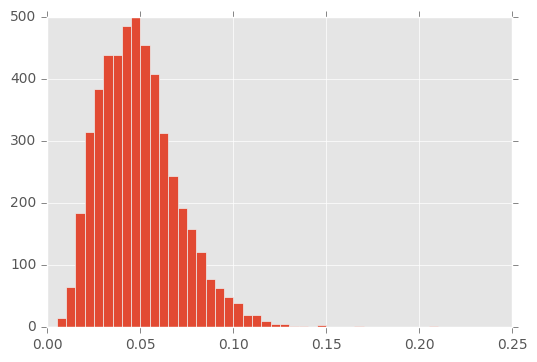

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # make plots look non-awful

abbins = [i/200 for i in range(50)]
plt.hist(pa_estimates, bins=abbins);

These are the "good" guesses, i.e. guesses that yielded simulated observations that looked like the real thing.

You can think of the y-axis scale as a measure of probability. The higher the bar, the more likely the "true" conversion fraction is that value.

The most probable value is around 0.04.

Now, at this point you may be saying: "I could have told you it was 0.04 when you told me 4/100 visitors converted." And you'd be right. 4/100 gives you a thing that is generally known as the _maximum likelihood_ estimate. It's often very easy to calculate.

But that maximum likelihood estimate doesn't tell the whole story. The number of conversions divided by the number of visitors is very likely close to the "true" value if we waited until we had a million or a billion visitors, but we only had 100. To see how this might be a problem, let's finish the A/B test by looking at layout B.

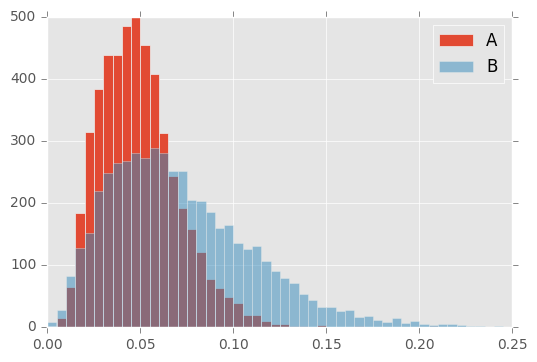

In [13]:
pb_estimates = estimateconversion(nb, obsb)
plt.hist(pa_estimates, bins=abbins, label='A')
plt.hist(pb_estimates, bins=abbins, label='B', alpha=0.5)
plt.legend();

The most likely value of layout B's conversion fraction is around 0.05, which is better than the most likely value of layout A's conversion fraction.

But! If you think about these as probability distributions, it's quite possible that the conversion fraction for layout B is as low as 1-2%, and it's not impossible that the conversion fraction of layout A is as high as 8-10%

When we're conducting an A/B test, we don't necessarily care about the absolute values of these conversion fractions: we care much more about which is better. How can we answer this question with these two distributons? Very simply!

In [14]:
b_better = []
for a, b in zip(pa_estimates, pb_estimates):
    b_better.append(b > a)

`b_better` is a list of 5000 booleans indicating whether the conversion fraction inferred for layout is better than that inferred for A. Here's the first ten.

In [15]:
print(b_better[:10])

[True, True, True, False, False, True, True, False, False, False]


Again we can make use of the fact that the sum of a list of booleans is the number of Trues it contains. We can use that fact to compute the fraction of samples for which B is better than A.

In [16]:
print(sum(b_better)/len(b_better))

0.68


What this value is telling us is that, given the data, we are only 67% percent sure that layout B is better.

Our maximum likelihood estimates of 4% for layout A and 5% for layout B told us with certainty that B was better. But the certainty was an illusion. The probabilistic statement is a full description of what we know, given the data. This approach allows us to quantify the probability of both outcomes. Which allows us to quantify risk.

Maybe switching over to layout B would cost us $1m. In which case, we perhaps 67% is not confident enough to risk it. In that case, we'd run the A/B test for longer, and hopefully become more confident.
 
Stop stop here and use pa_estimates and pb_estimates ot answer a couple more questions. 

What's the probability pa is greater than 6%? 

And let's we'll only bother to switch to layout B if it's at least 1% better than layout A. What's the probability of this, given the data?

If you manage those, try experimenting by changing na, obsa, nb and obsb to see what happens to your answers. Don't make na or nb too large or the code will take a long time to run.

### Bayes theorem

I just made you eat your greens. You just used Bayes Theorem. You did it by simulation instead of mathematics. The algorithm we used, which avoids solving this equation, is called Approximate Bayesian Computation.

![](http://www.fastforwardlabs.com/report_images/ff05/2-02.png)

The probability that a hypothesis is true, given the observed data, is the _posterior probability_. Generally speaking, this is the thing you want to know. It's what your updated beliefs about the world following the experiment. This is what `pa_estimates` and `pb_estimates` are.

The probability that you'd get the observed data if the hypothesis were true, is the _likelihood_. The simulation and rejection process is implicitly how we evaluated this.

The probability the hypothesis was true before you conducted the experiment, is the _prior probability_. That was the function that generated trial values of the conversion fraction.
 
## 2. Functional Python and online learning

The code above was kind of ugly and problem specific. If we reimplement Approximate Bayesian Computation using a functional approach we can clean things up a lot.

We're going to compose together Python generators into a pipeline that takes in the prior and spits out a stream of samples from the posterior, to implement Approximate Bayesian Computation.

If you haven't seen generators before, they're one of Python's most powerful features. A generator is an object that yields values from a sequence or stream one at a time when you call `next()` on it.

Here's a finite generator, created using a generator comprehension, which is just like a list comprehension except instead of returning a list, it returns an object that yields values one at a time.

In [17]:
gen1 = (i for i in [1, "A", 3.14])
print(next(gen1))
print(next(gen1))
print(next(gen1))

1
A
3.14


We can also create a generator by hand, by writing a function that `yield`s instead of `return`s.

In [18]:
def gen2():
    yield 1
    yield "A"
    yield 3.14

We can run `list()` on a finite generator like this to get all the values.

In [19]:
print(list(gen2()))

[1, 'A', 3.14]


Now we can clean up this monstrosity we wrote in the previous part.

In [20]:
def simulateconversion(p, nvisitors):
    outcomes = []
    for _ in range(nvisitors):
        outcomes.append(random.random() < p)
    return sum(outcomes)

One of the most important characteristics of functional programming is that we don't mutate variables. In the function above, the list `outcomes` gets mutated every loop.

In [21]:
def simulateconversion(p, nvisitors):
    return sum(random.random() < p for _ in range(nvisitors))

This version is more concise, which unless taken too far, generally means it's more readable. It's also a little bit faster. And you can make nvisitors as large as you like because it doesn't hold the entire set of outcomes in memory at any one time. That's because the argument to `sum` is a generator comprehension.

Now here's the really cool bit about generators. They allow you to work with streams of data whose lengths you don't know in advance, and which may in fact be infinite.

In [22]:
import itertools

gen3 = itertools.count()

print(next(gen3))
print(next(gen3))
print(next(gen3))

0
1
2


The `count` function returns a generator that simply keeps count of how many times `next` has been called on it. We can keep calling `next` on `gen3` it and it will keep returning numbers. So we can't run `list` on it, because it's a list without an end. Which is to say, `gen3` is an infinite generator.

We're going to be using infinite generators a lot, so let's set up a `take()` function that gives the next `n` items yielded by a generator. The will work fine with infinite generators. The recipe is taken from the excellent [itertools documentation](https://docs.python.org/3/library/itertools.html#itertools-recipes). It uses `islice` which takes a generator (even an infinite one), and returns another generator truncated to `n` items long.

In [26]:
def take(n, iterable):
    return list(itertools.islice(iterable, n))

Now, with that warmup — generators, generator expressions, and the `take` function — we can make our pipeline. At one end it's going to take in possible values of the conversion fraction, the prior, and spit out a stream of samples from the posterior at the other. And it's going to yield these samples for as long as you like.

TODO: stream schematic here!

First we'll make a generator that yields an infinite stream of trial values from the prior. 

We start with `prior`, which is a list of possible values for the unknown parameter we're trying to learn. We take a copy, shuffle it, then use `cycle` from itertools.  `cycle` takes a iterable and returns elements from it until they are exhausted, then repeats the sequence again indefintely, for as long as you want.

Bonus question: why do I take a copy of `prior`?

In [24]:
def prior_sampler(prior):
    prior = list(prior)
    random.shuffle(prior)
    # cycle is doing if you call: [a, b, c] --> [a, b, c, a, b, c, ....a, b, c] 
    return itertools.cycle(prior)

Let's see how this function works for a very simple prior, where we think the conversion fraction could be 1, 2, 3, 4 or 5%

In [27]:
prior = [0.01, 0.02, 0.03, 0.04, 0.05]
n = 12
print(take(n, prior_sampler(prior)))

[0.03, 0.05, 0.01, 0.04, 0.02, 0.03, 0.05, 0.01, 0.04, 0.02, 0.03, 0.05]


The next step in the ABC algorithm is, for each of the samples we get from prior_sampler, to simulate a set of observations.

The next generator in the pipeline takes in the stream of priors from `prior_sampler` and spits out a stream of `(simulation, prior)` tuples.

In [28]:
def simulation_sampler(simulate, prior_sampler):
    return ((simulate(p), p) for p in prior_sampler)

To make this function general, I made the function used to generate the simulation one of its arguments. You can treat functions like any other object in Python, and that includes passing them as arguments.

Let's take make what this generator does concrete by using `simulateconversion()` as the `simulate` function. Now remember that `simulateconversion()` takes two arguments, conversion probability `p` and number of visitors `nvisitors`. Here's the code for it, which we looked at in the previous part.

But `simulation_sampler` needs a callable that takes only one argument, a trial sample from the prior. So we need to turn `simulateconversion` into a function that takes one parameter

We can do this using `functools.partial` to make a new callable with a baked in, fixed value for the `nvisitors`.

In [29]:
import functools

simulateconversion_na = functools.partial(simulateconversion, nvisitors = na)

Here's how that partially evaluated (or curried) function works

In [30]:
simulateconversion_na(0.04)

3

Note we didn't have to tell the `simulation_na` that there were `na` visitors. It knew. We only had to tell it the conversion fraction.

Now we're finally able to use `simulation_sampler` to take the stream of trial prior samples and spit out a stream of `(simulation, prior)` tuples.

In [31]:
take(5, simulation_sampler(simulateconversion_na, prior_sampler(prior)))

[(5, 0.05), (1, 0.02), (3, 0.04), (0, 0.03), (0, 0.01)]

The final piece of the ABC pipeline is another generator that takes the output from simulation_sampler and filters out all the tuples yielded by `simulation_sampler` whose first elements do not look like the real observation.

We can do that with a simple generator expression with an `if` filter. The filter uses a callable function that compares two observations (or a simulation and a real observation), and returns True if they are similar. 

Finally we're ready to put this all together and implement Approximate Bayesian Computation.

In [32]:
def abayes(prior, obs, simulate, compare):
    priors = prior_sampler(prior)
    simulations = simulation_sampler(simulate, priors)
    posterior_sampler = (p for sim, p in simulations if compare(sim, obs))
    return posterior_sampler

`priors` here is an infinite generator of prior samples made from the list of possible values `prior` we passed in.

`simulations` is an infinite generator of (prior, simulation) tuples made by calling `simulate` on each prior sample in the stream from `priors`.

`posterior_sampler` is an infinite generator of samples from the prior filtered down to only those whose simulations that look like the observed data.

Let's use it for layout A in the A/B test in the previos part. We'll try values for the conversion fraction that go from 0 to 1 in steps of 0.001. This is our prior.

In [33]:
prior = [p1000/1000 for p1000 in range(1000)]

pa_posterior_sampler = abayes(prior,
                              obsa,
                              simulateconversion_na,
                              compareconversion)

`pa_posterior_sampler` is a potentially infinite generator, waiting for us to ask it for values. The values it yields are samples from the posterior distribution. Let's draw ten.

In [34]:
take(10, pa_posterior_sampler)

[0.027, 0.066, 0.039, 0.024, 0.056, 0.078, 0.036, 0.057, 0.108, 0.053]

Looking good. What about the layout B sampler, and let's ask for 5000 samples from each? Remember we had a different number of visitors for layout B, so we need to make another partial function.

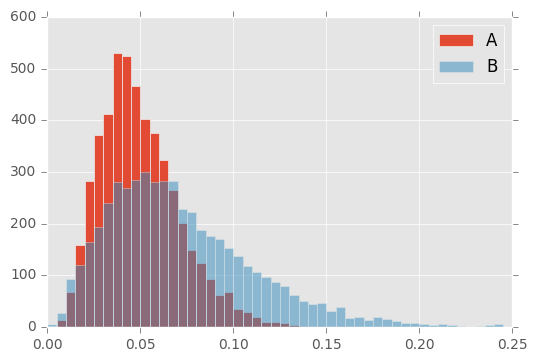

In [35]:
simulateconversion_nb = functools.partial(simulateconversion, nvisitors=nb)
pb_posterior_sampler = abayes(prior,
                              obsb,
                              simulateconversion_nb,
                              compareconversion)

nsamples = 5000
pa_samples = take(nsamples, pa_posterior_sampler)
pb_samples = take(nsamples, pb_posterior_sampler)

plt.hist(pa_samples, bins=abbins, label='A')
plt.hist(pb_samples, bins=abbins, label='B', alpha=0.5)
plt.legend();

## Online learning

What have we gained, apart from some clever code.

We've used Bayes's rule to turn beliefs prior to an experiment (that the conversion fraction is somewhere between 0 and 1) into beliefs after an experiment, the posterior.

Bayesians sometimes say "today's posterior is tomorrow's prior". What they mean is, if we then go on to do another experiement, we can use the posterior from the previous experiement as a new prior.

This allows us to do "online learning", i.e. to update our beliefs continually as data arrives. Imagine if, instead of being given the final results of the performance of layout A after 100 visitors, we were given the results every 20 visitors.

In [38]:
hourly_obs = [1, 0, 2, 0, 1]

Now we can use our `abayes` function to set up an "online" experiment that uses new data as it arrives.

We do this by writing a generator that yields up the posterior after an observation, and then uses that posterior as the prior for the next round.

In [36]:
# todays posterior is tomorrows prior bayesians are saying
def online_abayes(prior, obses, simulate, compare, nsamples=10000):
    for obs in obses:
        posterior = take(nsamples, abayes(prior, obs, simulate, compare))
        yield posterior
        prior = posterior

This generator very literally encodes the idea that "today's posterior is tomorrow's prior" in its final line. Let's use it.

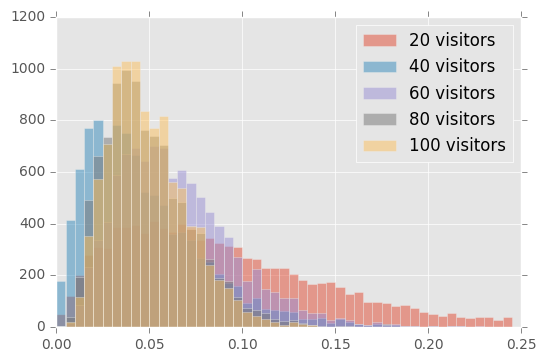

In [39]:
simulateconversion_online = functools.partial(simulateconversion, nvisitors=20)

posteriors = list(online_abayes(prior,
                                hourly_obs,
                                simulateconversion_online, 
                                compareconversion))

for i, p in enumerate(posteriors, 1):
    plt.hist(p, bins=abbins, label=str(i*20) + ' visitors', alpha=0.5)

plt.legend();

Note that the posterior distribution gets narrorwer as we collect more visitors. This means we're becoming more confident, which makes sense. 

This online approach allows us to make quantitative statements much earlier on. We can stop the experiment the minute we become confident enough. 

And it allows us to smoothly transition from a reigime in which we're depending on our best guess (the prior), to one where our beliefs are dominated by data.

## 3. Improving performance and the German tank problem

The final part of this tutorial is about the performance. Approximate Bayesian Computation is a brute force algorithm. It works, but it's not quick. We'll look at a way of speeding it up that will allow us to solve a slightly tougher problem, and a statistics classic. And finally we'll use a "real" probabilistic programming language to solve the same problem.

So, firstly, remember the A/B test. We had 4/100 visitors convert on layout A. That's a pretty small test. What if we had ten times more data: 1000 visitors, 40 of whom converted. Let's time how long it takes to draw just 1 sample from the posterior in that case

In [40]:
nbig = 1000
obsbig = 40
simulateconversion_big = functools.partial(simulateconversion, nvisitors=nbig)
pa_sampler_big = abayes(prior, obsa, simulateconversion_big, compareconversion)

%timeit take(1, pa_sampler_big)

1 loop, best of 3: 618 ms per loop


Let's compare this to the data we worked with before: 100 visitors, 4 of whom converted

In [41]:
pa_sampler = abayes(prior, obsa, simulateconversion_na, compareconversion)

%timeit take(1, pa_sampler)

100 loops, best of 3: 3.79 ms per loop


We collected 10 times more data, but the calculation takes 50-100 times longer. This is catastrophic news for our algorithm.

Why is it so slow? The problem is, the "acceptance rate" is extremely small. That's because the probability of a simulation _exactly_ matching the observation is very low.

Imagine I toss a coin 100 times. The most likely outcome is 50 heads. It's more likely than all the other possibilities. But the probability of getting exactly fifty heads is very small. This is the same deal. If the conversion fraction is 4% and 100 people visit, the most likely outcome is that 4 people convert. But the probability that _exactly_ 4 people convert is small.

And we need to get it _exactly_ right to yield up a sample from the posterior. 

What's the solution? The simplest thing to do is relax the requirement that they agree exactly. We can do this by changing to compare function to give it some "fuzziness", so that we accept simulations that look roughly like the observations within some tolerance.

In [42]:
def compareconversion_fuzzy(obs1, obs2, tol=0.1):
    return abs(obs1 - obs2)/(obs1 + 1) < tol

This function returns True if the difference between obs1 and obs2 is less than 10% of the value of obs1. The `+1` is in there to make sure we don't divide by zero.

In [43]:
pa_sampler_big_fuzzy = abayes(prior, obsbig, simulateconversion_big, compareconversion_fuzzy)

%timeit take(1, pa_sampler_big_fuzzy)

10 loops, best of 3: 36 ms per loop


That's a nice big speedup of a factor of 10 or so. But you get nothing for free! I'll leave it to you to investigate this, but the fuzzy comparison means that you get a fuzzy posterior. The peak will be in the right place, but it will be smeared out.

But now we have an idea that will allow us to run ABC on a statistics classic.

### The German tank problem

This is a German tank problem, which was faced by Allied forces during the Second World War.

German tanks we assigned a serial number when they rolled off the production line. The first tank was number 0, the next was number 1, and so on, up to `N-1`, the last tank. The Allies capture `m` tanks and can read their serial numbers.

The question is: given those `m` serial numbers, how many tanks does Germany have, i.e. what is `N`?

You can solve this problem "analytically", by writing down equations and solving integrals. There was an analytic solution to the A/B test problem too. But we've now set up the apparatus to solve it by simulation using Approximate Bayesian Computation.

To use our function `abayes()` we need a prior, an observation, a function to simulate the observation given values of `N` and `m`, and a function to compare an observation with a simulation.

Let's start with the observation and the simulation function. With A/B testing the observation was a simple number. With the German Tank Problem it's a bit more complicated: it's a list, the serial numbers of the captured tanks. Here's a function to simulate the observation, given `N` and `m`:

In [44]:
def simulatetanks(N, m):
    return random.sample(range(N), m)

This function uses `sample` to make sure we don't get the same number twice. You can't catch a tank twice.

Let's say, there are in reality 1000 tanks and the Allies capture two.

In [50]:
ntanks = 1000
nobs = 2

obstanks = simulatetanks(ntanks, nobs)
print(obstanks)

[244, 940]


So we've got our observation, and a function to simulate observations. Next the prior.

The Allies know the Germans have at least `max(obs)` tanks. And let's say they know that they have no more than 5000. So a reasonable prior might be the integers in this range

In [51]:
priortanks = range(max(obstanks), 5000)

Finally, we need a function to compare the serial numbers of the observed tanks and the results of a simulation. 

Again, to speed things up, we'll give our function a tolerance, so that the simulation needs to be similar to the observations, rather than identical.

In [52]:
def comparetanks(obs1, obs2, tol=20):
    return all(abs(o1 - o2) <= tol 
               for o1, o2 in zip(sorted(obs1), sorted(obs2)))

Now we're all set to run `abayes`

In [53]:
posterior_tank_sampler = abayes(priortanks, obstanks,
                                functools.partial(simulatetanks, m=nobs),
                                comparetanks)

tank_samples = take(1000, posterior_tank_sampler)

In a second I'm going to plot the answer we got. But also, to prove everything we've done in these three tutorials was correct, I'm going to overplot the analytic solution to this problem, i.e. this is the known correct answer.

These exist for some problems, but not all, which is why simulation-based methods like Approximate Bayesian Computation are so useful.

Now, you'll have to take my word for it that this function is the analytic solution.

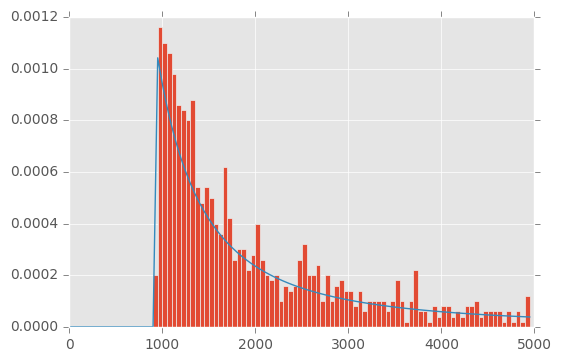

In [54]:
from math import factorial


def binom(x, y):
    return factorial(x)//(factorial(y) * factorial(x - y))


def analytic_solution(n, obs):
    '''Probability that there are n tanks given a list of observed serial numbers.'''
    k = len(obs)
    if k < 2:
        raise ValueError("len(data) = {}. Analytic formula valid for len(data) >= 2.".format(k))
    m = max(obs)
    if n < m:
        return 0.0
    else:
        return (k - 1)/k * binom(m - 1, k - 1)/binom(n, k)


tankbins = range(0, 5000, 50)
plt.hist(tank_samples, normed=True, bins=tankbins)
plt.plot(tankbins, [analytic_solution(x, obstanks) for x in tankbins]);

### Probabilistic programming

We've built up a very simple probabilistic programming system. That's the function `abayes`. It conceals some of the complexity of a particular approach to Bayesian inference.

To use it, all you have to do is:
   - observe some data
   - come up with a prior distribution the parameter you'd like to know
   - write a function that takes a sample from that distribution and simulates data
   - write a function that compares an observation and a simulation

But we hit a major performance bottleneck that required us to make the algorithm approximate in order to make progress. Our solution, fuzzy comparions, allowed us to solve not only a very simple problem with one parameter and one observation, A/B testing, but also a slightly more complex problems, with one parameter and two observations.

But this doesn't scale. Interesting problems often have tens, hundreds or even thousands of parameters, sometimes with complex interpendencies. There's no easy way we make the acceptance rate high enough for those problems.

At this point, you need to graduate to industrial strength sampling algorithms. The best-known examples are Markov Chain Monte Carlo (which includes Metropolis Hastings and Gibbs sampling) and Hamiltonian Monte Carlo. And the new hotness is ADVI. These are super fast, but a little bit fiddly to implemement.

The good news is, there are probabilistic programming systems that, like ours, abstract away the algorithmic complexity, but of these much smarter, faster, rather than brute force ABC.

To finish this series, let's resolve the German tank problem using an off-the-shelf probabilistic programming system called pymc3. Not only is it faster, it makes specifying your simulation process much easier because fundamental ideas like random variables and distributions are primitive objects that can be composed together.

Here's the whole German Tank Problem, specified and solved in ABC.

In [60]:
# bug here pymc3 samples with replacement
from pymc3 import DiscreteUniform, Model, sample

with Model():
    ntanks = DiscreteUniform('ntanks', lower=max(obstanks), upper=5000)
    obs = DiscreteUniform('obs', lower=0, upper=ntanks, observed=obstanks) 
    trace = sample(10000)

ModuleNotFoundError: No module named 'pymc3'

That was ten times more samples in a tenth the time. And if you increase `nobs` the difference in speed becomes huge.

Let's just check the answer is correct.

In [ ]:
burn_in = 1000
plt.hist(trace[burn_in:].get_values('ntanks'), normed=True, bins=100)
plt.plot(tankbins, [analytic_solution(x, obstanks) for x in tankbins]);

So for "real" problems you should use pymc3.

But Approximate Bayesian Computation is a great way to build up intution about the role of the prior, the generative model (the fancy name for the simulation function we wrote for each problem), and how to use the posterior to answer arbitrary questions probabilistically.

## What next

 - I have five coins. They are all equally unfair, i.e. they all have the same probability `p` of coming up heads. I toss each coin ten times and get [5, 3, 2, 4, 3] heads. Use `abayes` to figure out the posterior probability distribution of `p`. What's the probability that `p` is greater than 0.5, i.e. the coin has a bias toward heads?
 - Try changing the priors we used in this notebook. We used uniform priors, i.e. we specified a range of possible values, and said all were equally likely. Change the range of possible values. Change the way you build the list of possible priors. to make some values more likely than others. See how this affects the posterior.
 - If you followed all this and found it easy, take a look at [Markov Chain Monte Carlo without the Bullshit](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/) and see if you can write a similar system to `abayes` that uses the Metropolis Hastings algorithm. 
 - The pymc3 solution to the German Tank Problem has a tiny bug. It samples with replacement, which means it can generate fake observations of two tanks that have the same serial number. Google around and figure out how to fix this.

## TODO

- Discuss role of prior